In [1]:
#Dependencies and Set up 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import zscore

# Study data files
Vaccine_df = "Vaccination.csv"
# Read the mouse data and the study results
Vaccine_df = pd.read_csv(Vaccine_df, low_memory=False)
Vaccine_df

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_18PlusPop,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,12758.0,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,4687.0,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,1065968.0,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,16799.0,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,149676.0,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962776,12/13/2020,39001,51,Adams County,OH,0.0,0.0,0.0,NaN,NaN,...,21111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962777,12/13/2020,18061,51,Harrison County,IN,0.0,0.0,0.0,NaN,NaN,...,31495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962778,12/13/2020,48321,51,Matagorda County,TX,0.0,0.0,0.0,NaN,NaN,...,27278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962779,12/13/2020,54073,51,Pleasants County,WV,0.0,0.0,0.0,NaN,NaN,...,6077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
Vaccine_df = Vaccine_df.dropna(subset=['Recip_State'])


In [3]:
df = Vaccine_df[['Date','Recip_State','Completeness_pct']].dropna()
df[:5]

,Date,Recip_State,Completeness_pct
0,05/10/2023,WI,96.7
1,05/10/2023,IA,97.3
2,05/10/2023,NY,97.5
3,05/10/2023,TX,98.9
4,05/10/2023,MI,94.0


In [4]:
df.Date.replace('.+/','', regex=True, inplace=True)
df[:5]

,Date,Recip_State,Completeness_pct
0,2023,WI,96.7
1,2023,IA,97.3
2,2023,NY,97.5
3,2023,TX,98.9
4,2023,MI,94.0


In [5]:
df2 = df.groupby(['Date','Recip_State']).mean().reset_index()
df2[:5]

,Date,Recip_State,Completeness_pct
0,2020,AK,2.027032
1,2020,AL,1.071040
2,2020,AR,0.728522
3,2020,AS,0.000000
4,2020,AZ,6.889701


In [6]:
# Order the dataframe column 'Completeness_pct' from greatest to least for every individual year in the 'Date' column
df2 = df2.sort_values(['Date', 'Completeness_pct'], ascending=[True, False])
df2.head()

,Date,Recip_State,Completeness_pct
9,2020,DE,14.897260
13,2020,GU,13.636364
8,2020,DC,12.967647
7,2020,CT,8.928571
4,2020,AZ,6.889701


In [7]:
# First detect the outliers in the dataset and then delete the outliers and copy the rest of the elements to another array.
# Calculate z-scores of 'Completeness_pct'
df2['z_score'] = zscore(df2['Completeness_pct'])

# Only keep rows in dataframe with z-score less than absolute value of 3
clean_df = df2.loc[df2['z_score'].abs()<=3]

# Drop the 'z_score' column as it's no longer needed
clean_df = clean_df.drop('z_score', axis=1)

clean_df.head()

,Date,Recip_State,Completeness_pct
9,2020,DE,14.897260
13,2020,GU,13.636364
8,2020,DC,12.967647
7,2020,CT,8.928571
4,2020,AZ,6.889701


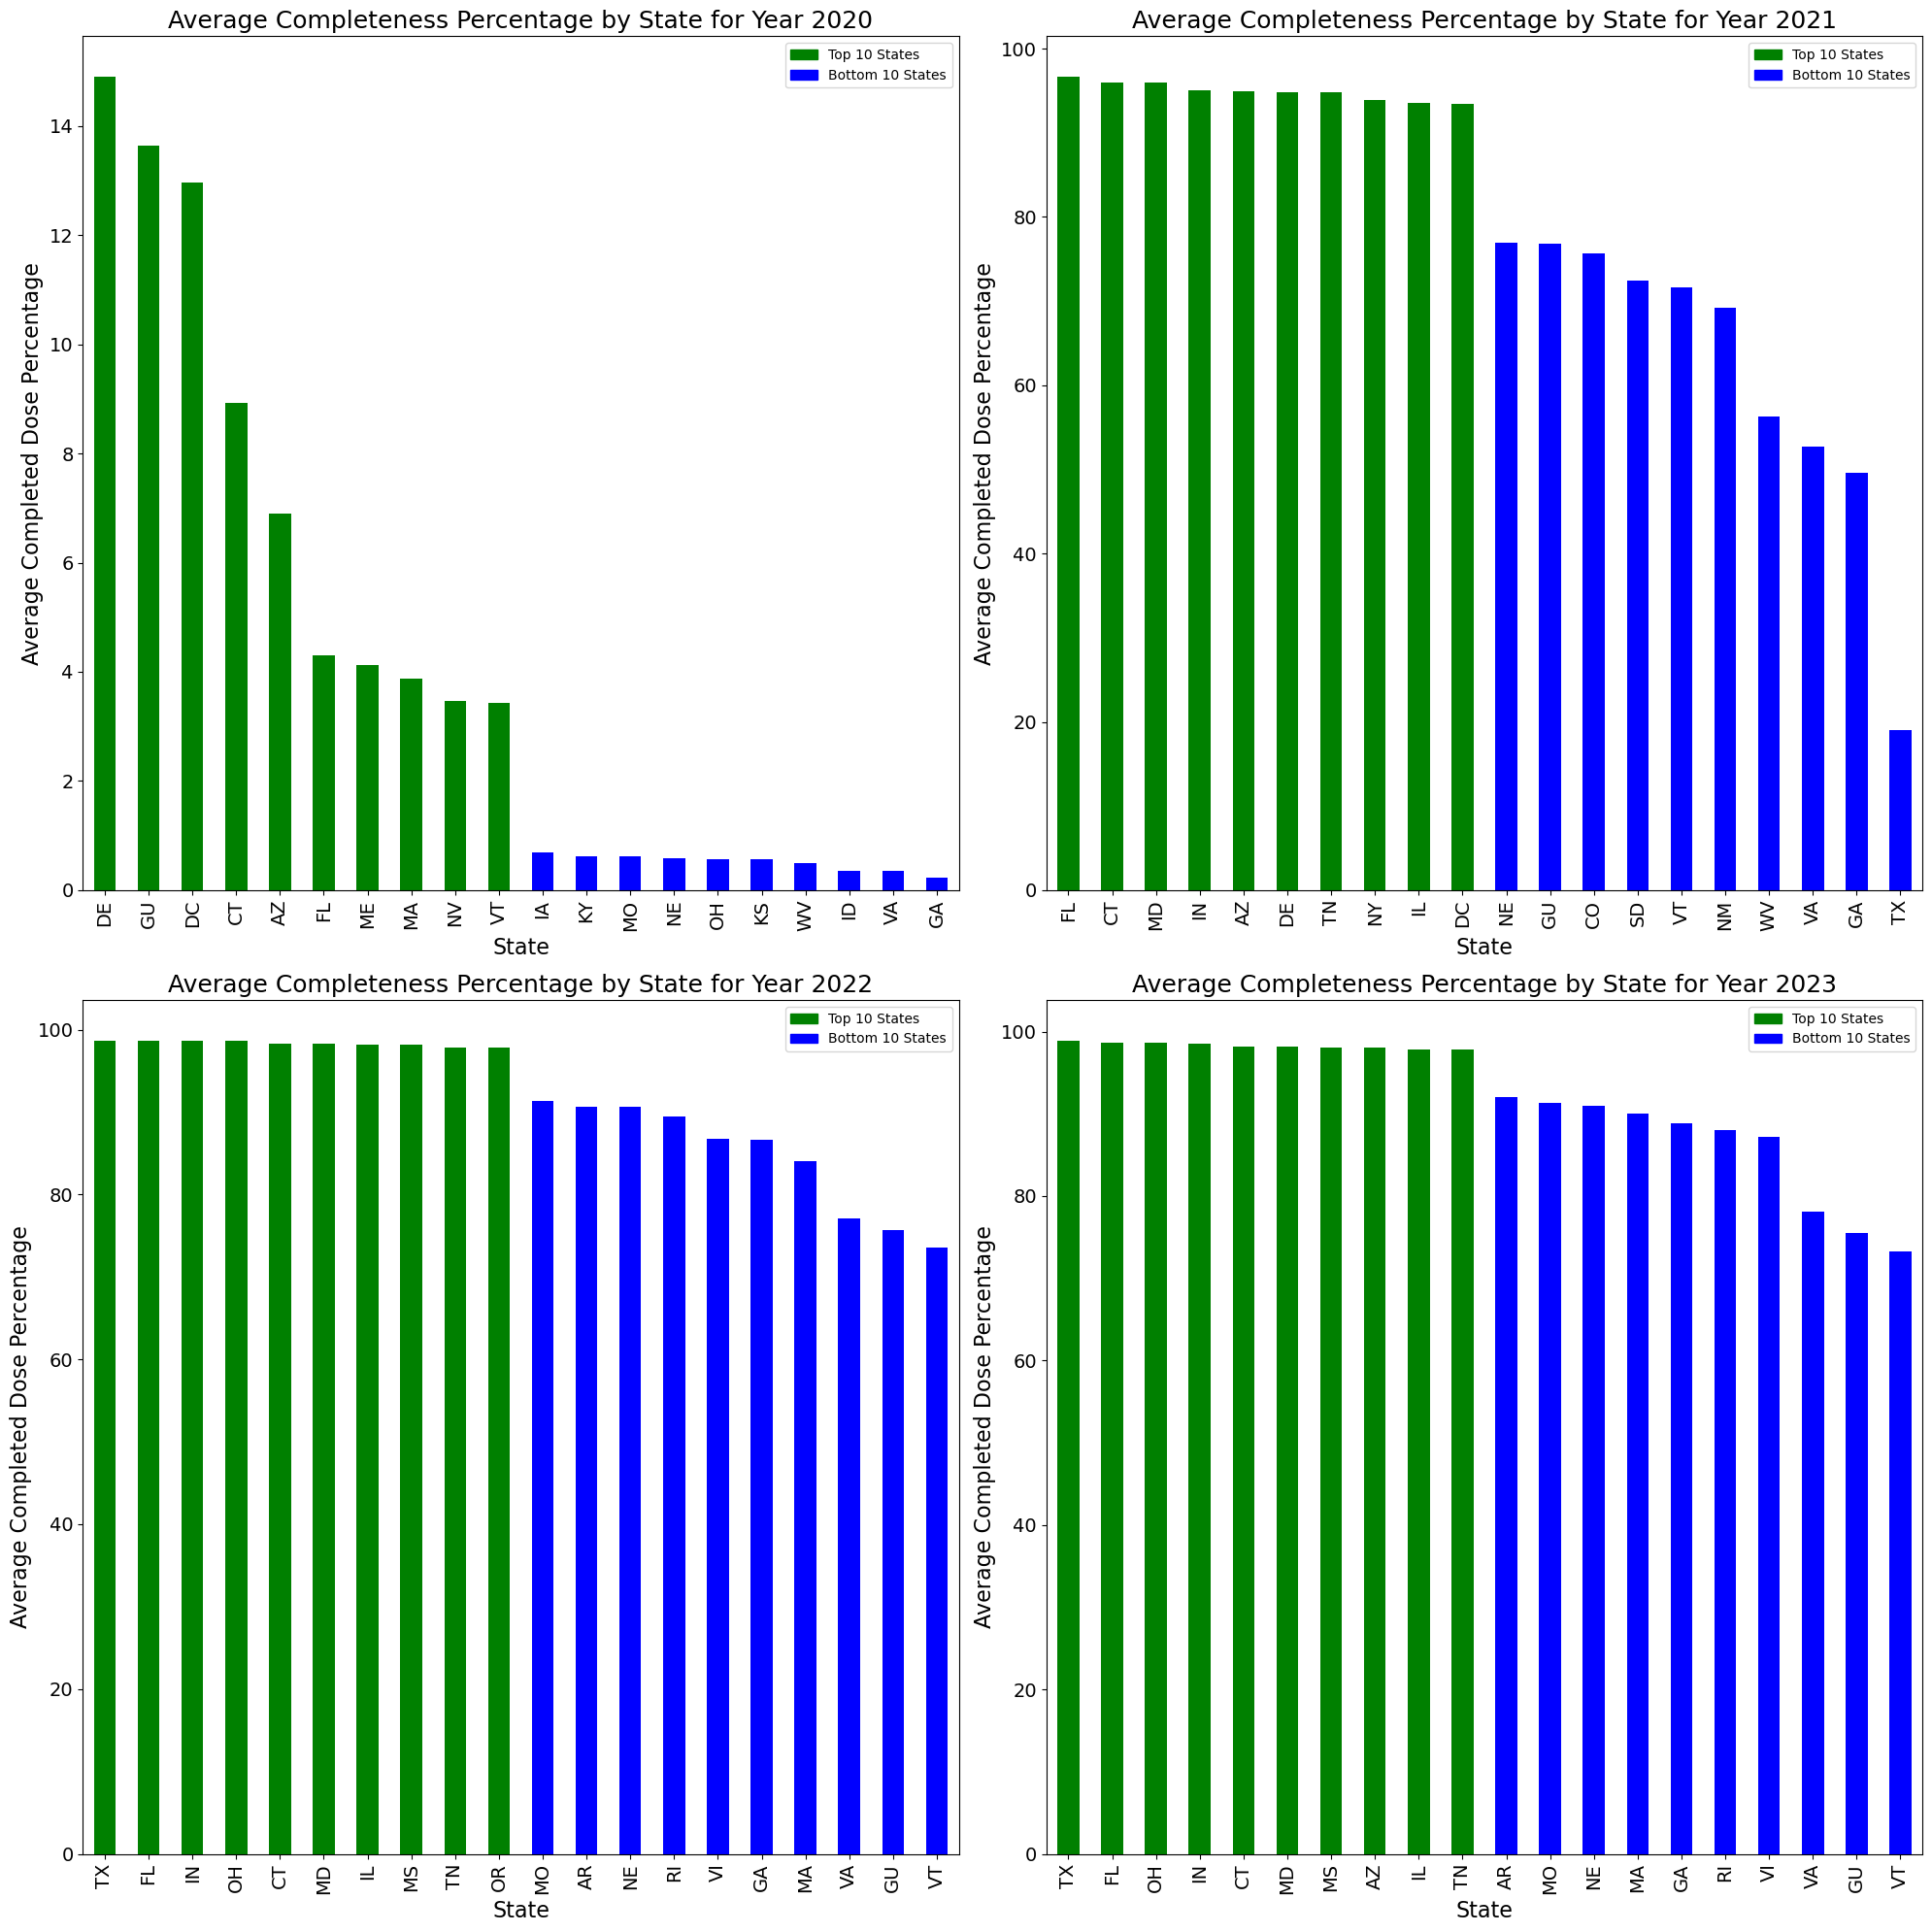

In [8]:
# Create a new column 'Year' from 'Date'
clean_df['Year'] = clean_df['Date'].str[:4]

# Get the unique years
years = clean_df['Year'].unique()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

# Flattening the axes array for easy indexing
axes = axes.flatten()

# Create the patches for the legend
legend_elements = [Patch(facecolor='green', edgecolor='green', label='Top 10 States'),
                   Patch(facecolor='blue', edgecolor='blue', label='Bottom 10 States')]

# Loop over the years and create a bar plot for each year
for i, year in enumerate(years):
    df_year = clean_df[(clean_df['Year'] == year) & (clean_df['Completeness_pct'] != 0)]
    df_year = pd.concat([df_year.head(10), df_year.tail(10)])
    colors = ['green' if x < 10 else 'blue' for x in range(len(df_year))]
    df_year['Completeness_pct'].plot(kind='bar', ax=axes[i], color=colors)
    axes[i].set_title(f'Average Completeness Percentage by State for Year {year}', fontsize=18)
    axes[i].set_xlabel('State', fontsize=16) 
    axes[i].set_ylabel('Average Completed Dose Percentage', fontsize=16)  
    axes[i].legend(handles=legend_elements)
    state_labels = df_year['Recip_State'].values
    axes[i].set_xticklabels(state_labels)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    
# Show the plot
plt.tight_layout()
plt.show()

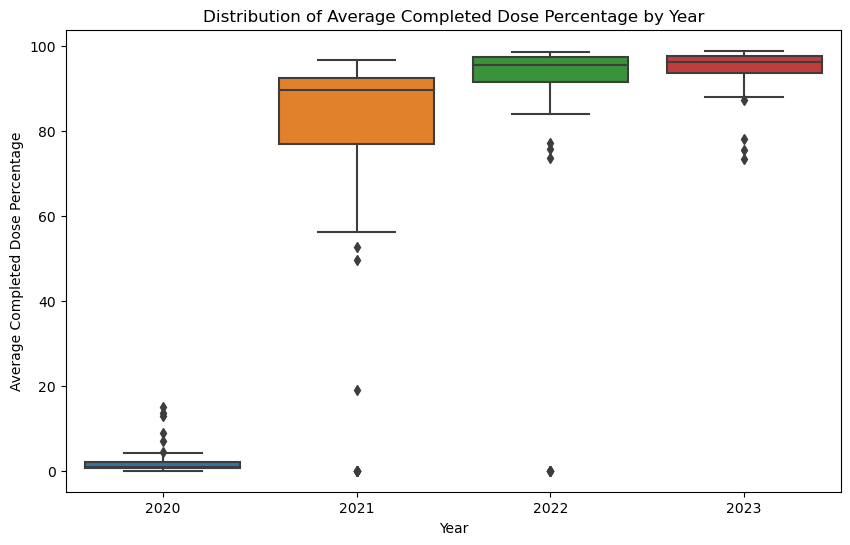

In [9]:
# # Identify the outliers using the Interquartile Range (IQR) method
# Q1 = clean_df['Completeness_pct'].quantile(0.25)
# Q3 = clean_df['Completeness_pct'].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds for the outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Replace outliers with median value of the 'Completeness_pct' column
# median = clean_df['Completeness_pct'].median()
# clean_df['Completeness_pct'] = np.where((clean_df['Completeness_pct'] < lower_bound) | 
#                                         (clean_df['Completeness_pct'] > upper_bound), 
#                                         median, clean_df['Completeness_pct'])

# Box plot after cleaning the dataset
plt.figure(figsize=(10,6))
sns.boxplot(x='Year', y='Completeness_pct', data=clean_df)
plt.title('Distribution of Average Completed Dose Percentage by Year')
plt.xlabel('Year')
plt.ylabel('Average Completed Dose Percentage')
plt.show()